# Finger prediction with EMSC as a preprocessing step

*Date: 10 Mar 2025*

**Objective**: To access the performance of EMSC as a preprocessing step for blood glucose prediction.

**Intuition**: Raman measurement is a linear combination of the spectra of the individual components.

$$ R = \sum_{i} c_{i} S_{i}  $$

where:
- $ R $ is the Raman measurement,
- $ c_{i} $ is the concentration level of component $ i $,
- $ S_{i} $ is the Raman spectrum of component $ i $.

In practice, the measurement $R$ could be skewed by a baseline which can be modeled as a polynomial function.

$$ R = \sum_{i} c_{i} S_{i}  + \sum_{j} a_{j} x^{j}$$

where:

- $ a_{j} $ is the coefficient of the polynomial of degree $ j $,
- $ x $ is the wavenumber.

Based on this idea, the Extended Multivariate Signal Correction (EMSC) will estimate the coefficients $ c_{i} $ and $ a_{j} $. 
This estimation can be seen as a linear regression problem where each $ S_{i} $ and $ x^{j} $ are the features and $ R $ is the target.

Any component $ S_{I} $ can be extracted from the measurement $ R $ with the following equation:

$$ \hat{S_{I}} = \frac{R  - \sum_{i \neq I} c_{i} S_{i}  - \sum_{j} a_{j} x^{j} }  {c_{I}} $$

where $ \hat{S_{I}} $ is an approximation of the actual component $ S_{I} $.



In [ ]:
raise Exception()
# This file use obsolete code. Just don't run it anymore.

In [13]:
from pathlib import Path
import matplotlib.pyplot as plt
from itertools import groupby
from functools import reduce

from raman.spectra import Blood, Reference, load_spectra_of_subject
from raman.sample import Sample


def add_plot_label():
    plt.xlabel("Raman Shift (cm^-1)")
    plt.ylabel("Intensity")
    plt.grid()
    
def accumulate(s1:Sample,s2:Sample):
    return s1 | s2

from scipy.interpolate import CubicSpline
import numpy as np

def get_samples(subject_id:str):
    subj_glucoses = []
    subj_idx = []
    subj_samples = []
    prev_id = -1
    for record in load_spectra_of_subject(subject_id=subject_id):
        # If newid
        if(prev_id != record.id):
            subj_samples.append(record.to_sample())
            if(record.glucose):
                subj_glucoses.append(record.glucose)
                subj_idx.append(record.id)
            prev_id = record.id
        else:
            # If same id, accumulate
            subj_samples[-1] = accumulate(subj_samples[-1], record.to_sample())
            # if(record.glucose):
                # subj_glucoses.append(record.glucose)
                # subj_idx.append(record.id)
    cs = CubicSpline(x=subj_idx, y=subj_glucoses)
    interp_glucoses = cs(np.arange(0, subj_idx[-1]+1))
    print(subj_glucoses)
    print(interp_glucoses)
    return subj_samples, list(interp_glucoses)

In [14]:
glucoses:dict[str,float] = []
samples:list[Sample] = []

for subject_id in ["s1", "s2", "s3", "s4", "s5", "s6", "s7", "s8"]:
    subj_samples, subj_glucoses = get_samples(subject_id=subject_id)
    samples += subj_samples
    glucoses += subj_glucoses
    assert len(samples) == len(glucoses), f"subject_id {subject_id} has different number of samples and glucoses"

Found 3 spike(s) in path=, self.remove_spike() is perform automatically.
Found 1 spike(s) in path=, self.remove_spike() is perform automatically.
Found 2 spike(s) in path=, self.remove_spike() is perform automatically.
Found 1 spike(s) in path=, self.remove_spike() is perform automatically.
Found 1 spike(s) in path=, self.remove_spike() is perform automatically.
Found 2 spike(s) in path=, self.remove_spike() is perform automatically.
Found 2 spike(s) in path=, self.remove_spike() is perform automatically.
Found 1 spike(s) in path=, self.remove_spike() is perform automatically.
Found 1 spike(s) in path=, self.remove_spike() is perform automatically.
Found 1 spike(s) in path=, self.remove_spike() is perform automatically.
Found 2 spike(s) in path=, self.remove_spike() is perform automatically.
Found 1 spike(s) in path=, self.remove_spike() is perform automatically.
Found 1 spike(s) in path=, self.remove_spike() is perform automatically.
Found 1 spike(s) in path=, self.remove_spike() is p

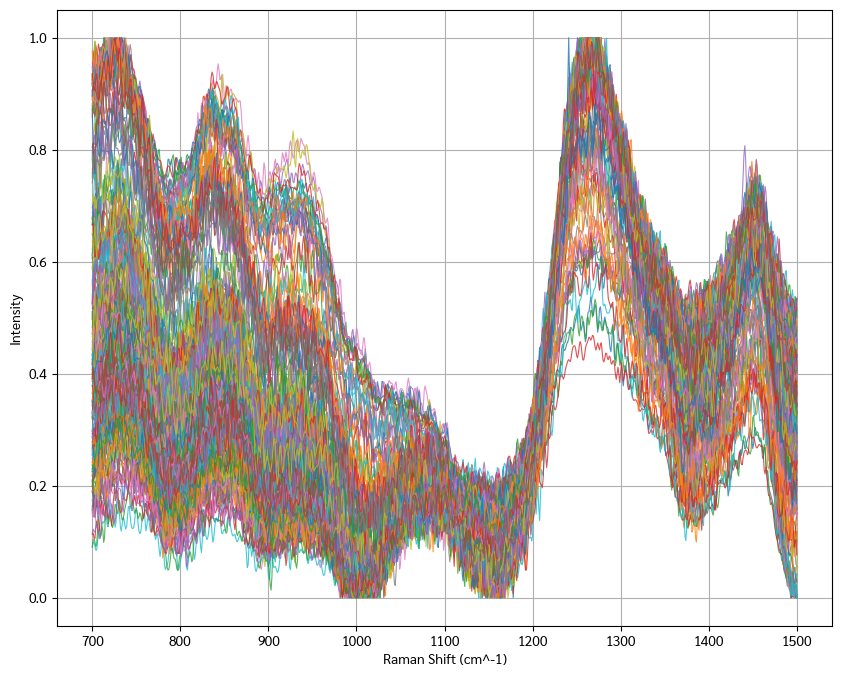

In [15]:
plt.figure(figsize=(10,8))
for sample in samples:
    sample.extract_range(low=700, high=1500)
    sample.normalized(method="minmax")
    sample.plot(label=f"{sample.date}")
# plt.legend()
add_plot_label()
plt.show()

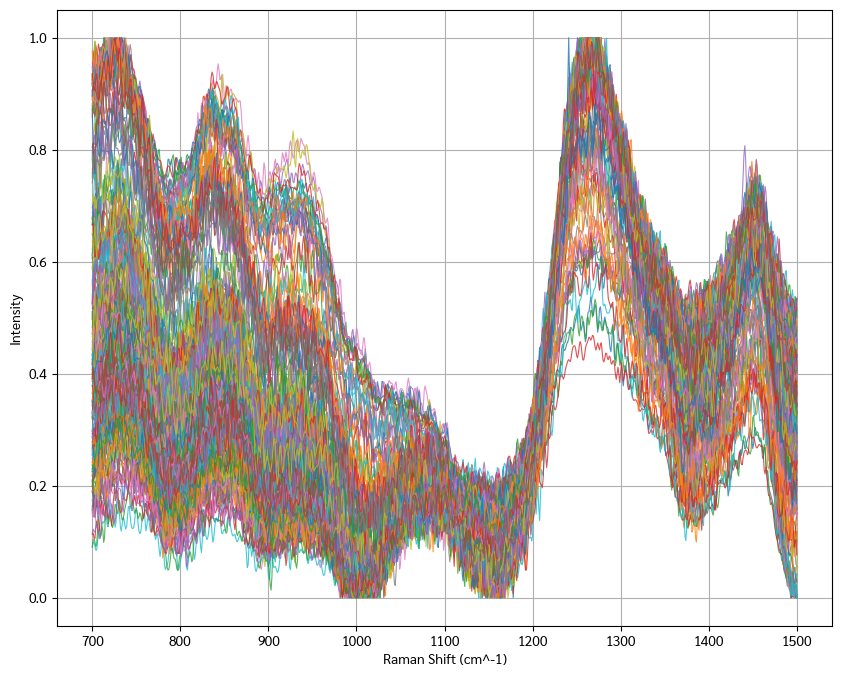

In [16]:
names:list[str]    = []
data :list[Sample] = []

for key, group in groupby(samples, key=lambda x: x.name):
    names.append(key)
    data.append(reduce(accumulate, group))

plt.figure(figsize=(10,8))
for sample in data:
    sample.plot(label=f"{sample.date}")
# plt.legend()
add_plot_label()
plt.show()

Found 1 spike(s) in path=, self.remove_spike() is perform automatically.
Found 1 spike(s) in path=, self.remove_spike() is perform automatically.


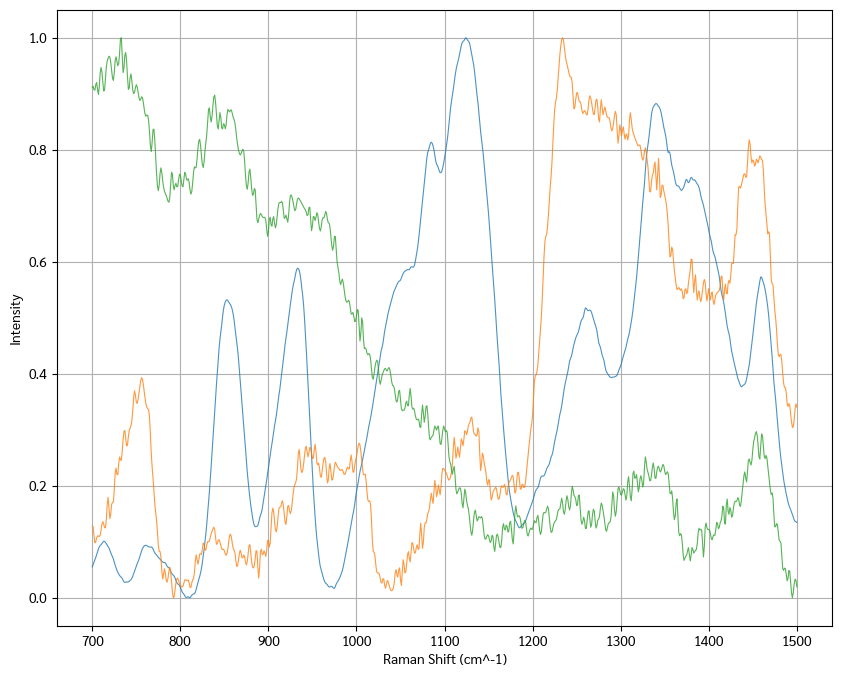

In [17]:
plt.figure(figsize=(10,8))
glucose = Reference.from_database("glucose").to_sample()
glucose.extract_range(low=700, high=1500)
glucose.normalized(method="minmax")
glucose.plot(label=f"{glucose.date}")
blood = Reference.from_database("blood").to_sample()
blood.extract_range(low=700, high=1500)
blood.normalized(method="minmax")
blood.plot(label=f"{blood.date}")
skin = Reference.from_database("skin").to_sample()
skin.extract_range(low=700, high=1500)
skin.normalized(method="minmax")
skin.plot(label=f"{skin.date}")
add_plot_label()
plt.show()

In [18]:
from raman.model import EMSC

emsc = EMSC(raman_shift=sample.x, order=3)
emsc.add_reference(blood.y, name="blood")
emsc.add_reference(skin.y, name="skin")
# emsc.add_reference(glucose.y, name="glucose")
emsc.fit(composite_signal=sample.y)
corrected_y = emsc.transform(composite_signal=sample.y)
sample_corrected = Sample(
    x=sample.x,
    y=corrected_y,
    interpolate=False,
)
sample_corrected.name = f"{sample.name}_corrected"

In [19]:
print(emsc.loss)
print(emsc.coefficients)

0.8536982185008676
[ 8.43289559e-01  1.26357667e-01  2.80701911e+00 -6.83462278e-03
  5.24853946e-06 -1.27644872e-09]


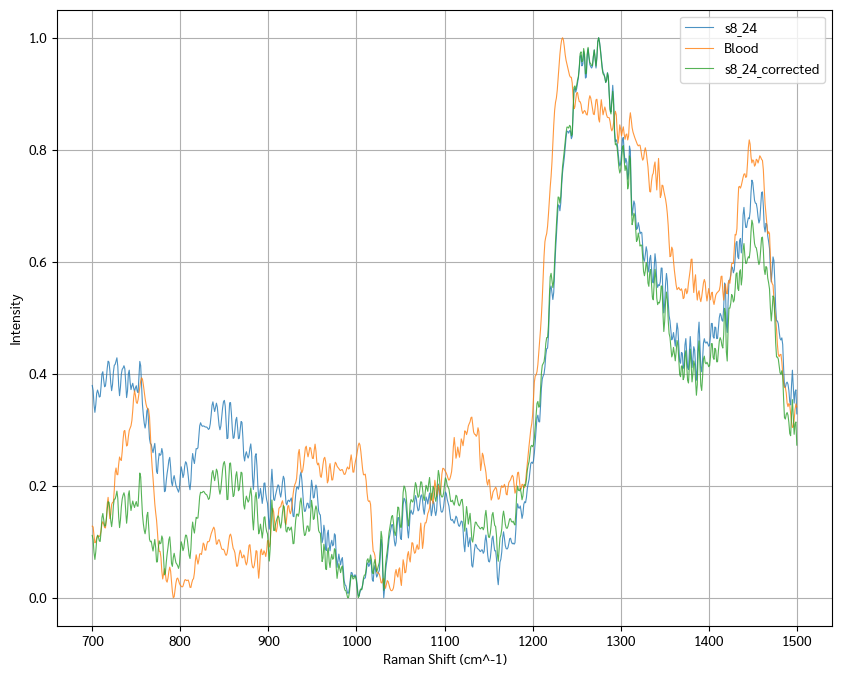

In [20]:
plt.figure(figsize=(10,8))
sample.plot(label=f"{sample.name}")
blood.plot(label=f"Blood")
sample_corrected.plot(label=f"{sample_corrected.name}")
plt.legend()
add_plot_label()
plt.show()

Processing EMSC for all signal of S1

In [21]:
def correction(sample:Sample):
    emsc = EMSC(raman_shift=sample.x, order=4)
    emsc.add_reference(blood.y, name="blood")
    emsc.add_reference(skin.y, name="skin")
    # emsc.add_reference(glucose.y, name="glucose")
    emsc.fit(composite_signal=sample.y)
    corrected_y = emsc.transform(composite_signal=sample.y)
    sample_corrected = Sample(
        x=sample.x,
        y=corrected_y,
        interpolate=False,
    )
    sample_corrected.name = f"{sample.name}_corrected"
    return sample_corrected

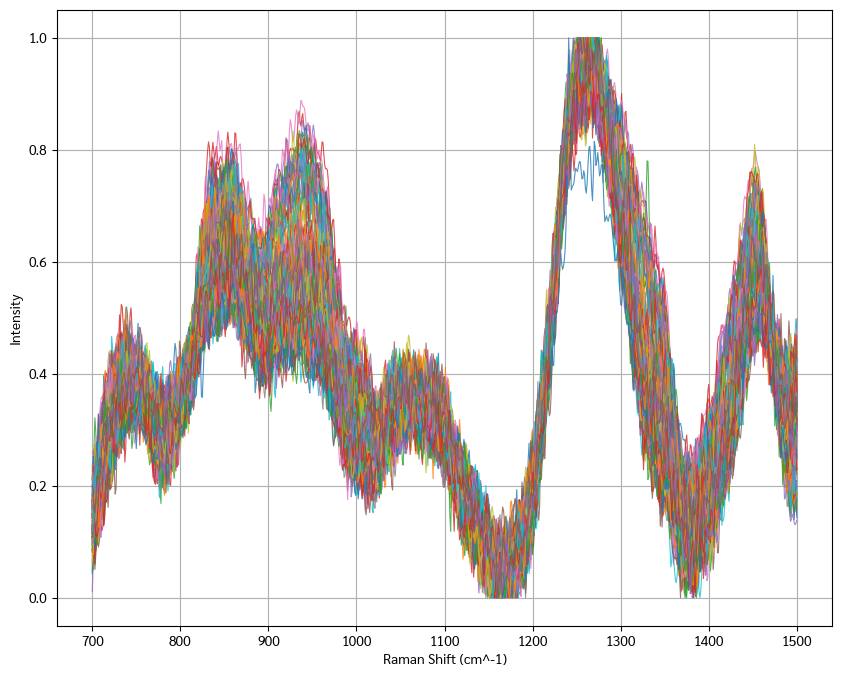

In [22]:
plt.figure(figsize=(10,8))

s_911s = []
s_1125s = []
s_1060s = []
s_1450s = []

corrected__samples = [ ]
for sample in data:
    corrected_sample = correction(sample)
    s_911s.append(corrected_sample.at(range(905,915)).mean())
    s_1125 = corrected_sample.at(range(1120,1130))
    s_1125s.append(s_1125.mean())
    s_1060s.append(corrected_sample.at(range(1050,1070)).mean())
    s_1450s.append(corrected_sample.at(range(1440,1460)).mean())
    
    corrected_sample.plot()
    corrected__samples.append(corrected_sample)

# plt.legend()
add_plot_label()
plt.show()


In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor

from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
X = np.vstack([s_911s, s_1125s, s_1060s, s_1450s]).T
y = np.array(glucoses)
rkf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=42)
# rkf.get_n_splits(X,y)
models = [LinearRegression(), 
          RandomForestRegressor(), 
          GradientBoostingRegressor(), 
          AdaBoostRegressor()
        #   MLPRegressor()
          ]

mses = []
r2s = []
preds = []
best_r2 = -1

for model in models:
    best_mse = -1
    best_model = None
    for i, (train_index, test_index) in enumerate(rkf.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        # r2 = r2_score(y_true=y_test, y_pred=y_pred)
        mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
        if mse < best_mse or best_mse == -1:
            best_mse = mse
            best_model = model

    y_pred = best_model.predict(X)
    r2 = r2_score(y_true=y, y_pred=y_pred)
    mse = mean_squared_error(y_true=y, y_pred=y_pred)
    preds.append(y_pred)
    mses.append(mse)
    r2s.append(r2)
    if(r2 > best_r2):
        best_r2 = r2
    print(f"{model.__class__.__name__} mse: {mse:.3f} r2: {r2:.3f}")

print("Best model:", best_model)
print("Best r2:", best_r2)


LinearRegression mse: 1157.625 r2: 0.122
RandomForestRegressor mse: 172.718 r2: 0.869
GradientBoostingRegressor mse: 183.190 r2: 0.861
AdaBoostRegressor mse: 689.268 r2: 0.477
Best model: AdaBoostRegressor()
Best r2: 0.8689874376659377


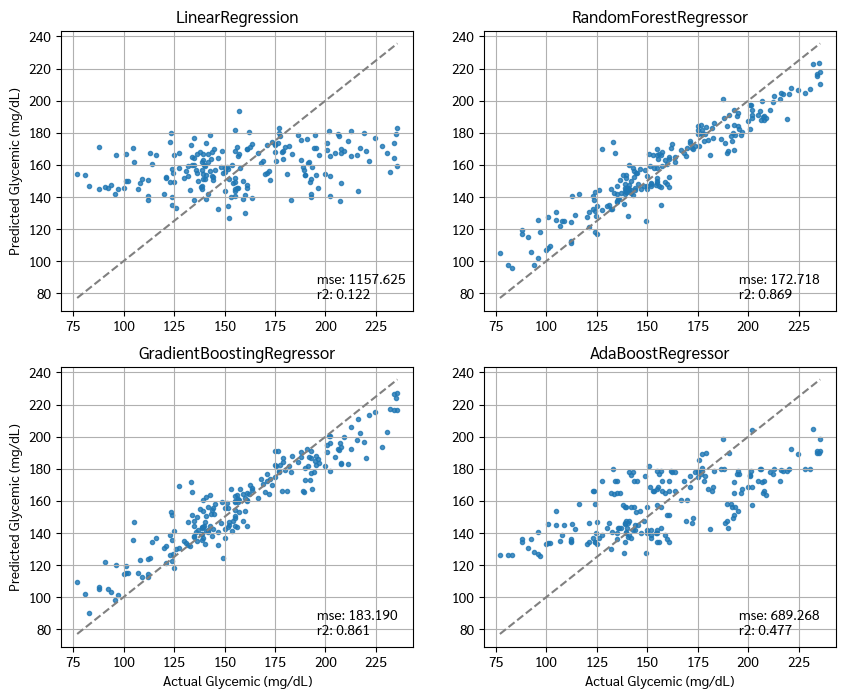

In [25]:
fig,ax = plt.subplots(figsize=(10,8), ncols=2, nrows=2)

idx = 0
for i in range(2):
    for j in range(2):

        start = min(y) if min(y) < min(preds[idx]) else min(preds[idx])
        end = max(y) if max(y) > max(preds[idx]) else max(preds[idx])
        ax[i][j].plot([start,end], [start,end], color='grey', linestyle='--')
        ax[i][j].scatter(x=y, y=preds[idx], alpha=0.8, marker='.')
        ax[i][j].grid()
        ax[i][j].set_title(f"{models[idx].__class__.__name__}")
        ax[i][j].text(x=end-40, y=start, s=f"mse: {mses[idx]:.3f}\nr2: {r2s[idx]:.3f}", fontsize=10)
        idx += 1


ax[0][0].set_ylabel("Predicted Glycemic (mg/dL)")
ax[1][0].set_ylabel("Predicted Glycemic (mg/dL)")
ax[1][0].set_xlabel("Actual Glycemic (mg/dL)")
ax[1][1].set_xlabel("Actual Glycemic (mg/dL)")

plt.show()